holidayとvisitorsのTarget-Encodingが有効！！

年末年始のmax()： 2300 -> 2280

In [1100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import seaborn as sns
sns.set()
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1101]:
from general_functions import *
from src.data.make_dataset import *

# 整形

## 学習データ

In [1102]:
train_raw = read_tsv("../data/train.tsv")
train, parkDict = format_train(train_raw)
train["is_test"] = 0
train.head()

(5848, 2)


,park,visitors,park_cate,is_test
datetime,,,,
2015-01-01,阿寒摩周国立公園,11028,0,0
2015-01-01,十和田八幡平国立公園,34757,1,0
2015-01-01,日光国立公園,29714,2,0
2015-01-01,伊勢志摩国立公園,42652,3,0
2015-01-01,大山隠岐国立公園,3637,4,0


In [1103]:
train["visitors_shift_7"] = train["visitors"].shift(8 * 7)
train["visitors_shift_14"] = train["visitors"].shift(8 * 14)
#train["visitors_shift_21"] = train["visitors"].shift(8 * 21)
train["visitors_shift_28"] = train["visitors"].shift(8 * 28)

## 予測データ

In [1104]:
test_raw = read_tsv("../data/test.tsv")
test_raw.index = test_raw.datetime
test_raw = test_raw.drop("datetime", axis=1)
test, _ = format_train(test_raw)
test["is_test"] = 1
test.head(10)

(2920, 2)


,park,park_cate,is_test
datetime,,,
2017-01-01,阿寒摩周国立公園,0,1
2017-01-01,十和田八幡平国立公園,1,1
2017-01-01,日光国立公園,2,1
2017-01-01,伊勢志摩国立公園,3,1
2017-01-01,大山隠岐国立公園,4,1
2017-01-01,阿蘇くじゅう国立公園,5,1
2017-01-01,霧島錦江湾国立公園,6,1
2017-01-01,慶良間諸島国立公園,7,1
2017-01-02,阿寒摩周国立公園,0,1


## 気象データ

In [1105]:
weather_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13140 entries, 2015/1/1 to 2017/12/30
Data columns (total 23 columns):
地点                   13140 non-null object
平均気温(℃)              12044 non-null float64
最高気温(℃)              12044 non-null float64
最低気温(℃)              12044 non-null float64
降水量の合計(mm)           13137 non-null float64
10分間降水量の最大(mm)       13137 non-null float64
日照時間(時間)             12019 non-null float64
合計全天日射量(MJ/㎡)        3283 non-null float64
最深積雪(cm)             8758 non-null float64
降雪量合計(cm)            8758 non-null float64
平均風速(m/s)            12044 non-null float64
最大風速(m/s)            12044 non-null float64
最大瞬間風速(m/s)          12044 non-null float64
最多風向(16方位)           12044 non-null object
平均蒸気圧(hPa)           5451 non-null float64
平均現地気圧(hPa)          5475 non-null float64
平均湿度(%)              5451 non-null float64
平均海面気圧(hPa)          4380 non-null float64
最小相対湿度(%)            5451 non-null float64
最低海面気圧(hPa)          4380 non-null float64
平均雲量(10分比)     

In [1106]:
weather_raw = read_tsv("../data/weather.tsv")
weather, pointDict = format_weather(weather_raw)

weather = weather[["最深積雪(cm)", "最大瞬間風速(m/s)", "park_cate"]]

weather.index = weather.index + timedelta(1)

weather["year"] = weather.index.year
weather["month"] = weather.index.month
weather["week"] = weather.index.week
weather["dayofweek"] = weather.index.dayofweek
weather["day"] = weather.index.day

#weather = weather.fillna(method='ffill')


weather = weather.groupby([weather.index, "park_cate"]).mean().reset_index()

weather.index = weather.datetime
weather.drop("datetime", axis=1, inplace=True)


(13140, 23)


## 休日データ

In [1107]:
holiday_raw = pd.read_csv("../data/holiday.csv")
holiday = format_holiday(holiday_raw)
holiday.head()

(1096, 19)


,year,month,day,is_holiday,prev_day_is_holiday,next_day_is_holiday,prev_day_is_holiday & is_holiday,next_day_is_holiday & is_holiday,prev_day_is_holiday & next_day_is_holiday & is_holiday,natsu-yasumi,fuyu-yasumi,haru-yasumi,gWeek,sWeek,obon,nenmatsu-nenshi,gWeek & sWeek,gWeek & sWeek & obon & nenmatsu-nenshi,natsu-yasumi & fuyu-yasumi & haru-yasumi
0,2015,1,1,1,NaN,0.0,NaN,1.0,NaN,0,1,0,0,0,0,1,0,1,1
1,2015,1,2,0,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0,0,1,0,1,1
2,2015,1,3,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,1,1
3,2015,1,4,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1
4,2015,1,5,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1


## ロケーション付SNSデータ

In [1108]:
nightley = read_tsv("../data/nightley.tsv")
nightley.index = pd.to_datetime(nightley.index)

# 1日ずらし
nightley.index = nightley.index + timedelta(1)

nightley["year"] = nightley.index.year
nightley["month"] = nightley.index.month
nightley["week"] = nightley.index.week
nightley["dayofweek"] = nightley.index.dayofweek
nightley["day"] = nightley.index.day

# park_cate付与
nightley["park_cate"] = 2 # 日光

japan_count = nightley.groupby(["year", "month", "park_cate"]).agg({"mean"})["Japan_count"].reset_index()
japan_count.columns = ["year", "month", "park_cate", "ja_mean"]
foreign_count = nightley.groupby(["year", "month", "park_cate"]).agg({"mean"})["Japan_count"].reset_index()
foreign_count.columns = ["year", "month", "park_cate", "fo_mean"]

(730, 2)



## 結合

In [1109]:
data = pd.concat([train, test], axis=0)
data["year"] = data.index.year
data["month"] = data.index.month
data["week"] = data.index.week
data["dayofweek"] = data.index.dayofweek
data["day"] = data.index.day
data.head()

,is_test,park,park_cate,visitors,visitors_shift_14,visitors_shift_28,visitors_shift_7,year,month,week,dayofweek,day
datetime,,,,,,,,,,,,
2015-01-01,0,阿寒摩周国立公園,0,11028.0,NaN,NaN,NaN,2015,1,1,3,1
2015-01-01,0,十和田八幡平国立公園,1,34757.0,NaN,NaN,NaN,2015,1,1,3,1
2015-01-01,0,日光国立公園,2,29714.0,NaN,NaN,NaN,2015,1,1,3,1
2015-01-01,0,伊勢志摩国立公園,3,42652.0,NaN,NaN,NaN,2015,1,1,3,1
2015-01-01,0,大山隠岐国立公園,4,3637.0,NaN,NaN,NaN,2015,1,1,3,1


In [1110]:
data.shape

(8768, 12)

In [1111]:
datasets = pd.merge(data, holiday, on=["year", "month", "day"])
datasets.index = data.index

In [1112]:
datasets = pd.merge(datasets, nightley, how="left")
datasets = pd.merge(datasets, japan_count, how="left")
datasets = pd.merge(datasets, foreign_count, how="left")

datasets.index = data.index

In [1113]:
datasets = pd.merge(datasets, weather, how="left")

datasets.index = data.index

# 公園ごとに分解

In [1114]:
data_list = []
for park in range(8):
    data_list.append(datasets[datasets["park_cate"] == park])

In [1115]:
sin_4 = np.sin(np.arange(1096 * 8) /365 * 4 * np.pi)
cos_4 = np.cos(np.arange(1096 * 8) / 365 * 4 * np.pi)
tan_4 = np.tan(np.arange(1096 * 8)  / 365 * 4 * np.pi)

datasets["sin_4"] = sin_4
datasets["cos_4"] = cos_4
datasets["tan_4"] = tan_4

# 傾向把握

In [1116]:
# for park in range(8):
#     plt.figure(figsize=(20, 12))
#     print(data_list[park]["park"][0])
#     plt.plot(data_list[park]["visitors"].values);
#     plt.show()

# 学習

## 学習準備

2252.383967358115


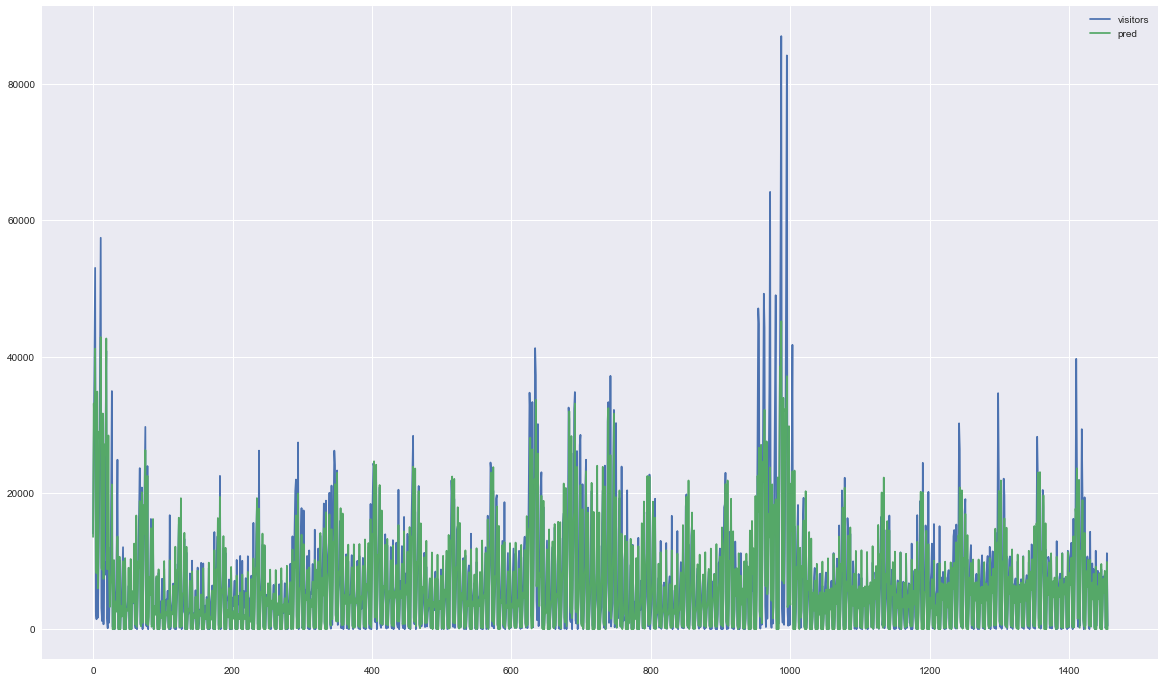

2355.1725892588984


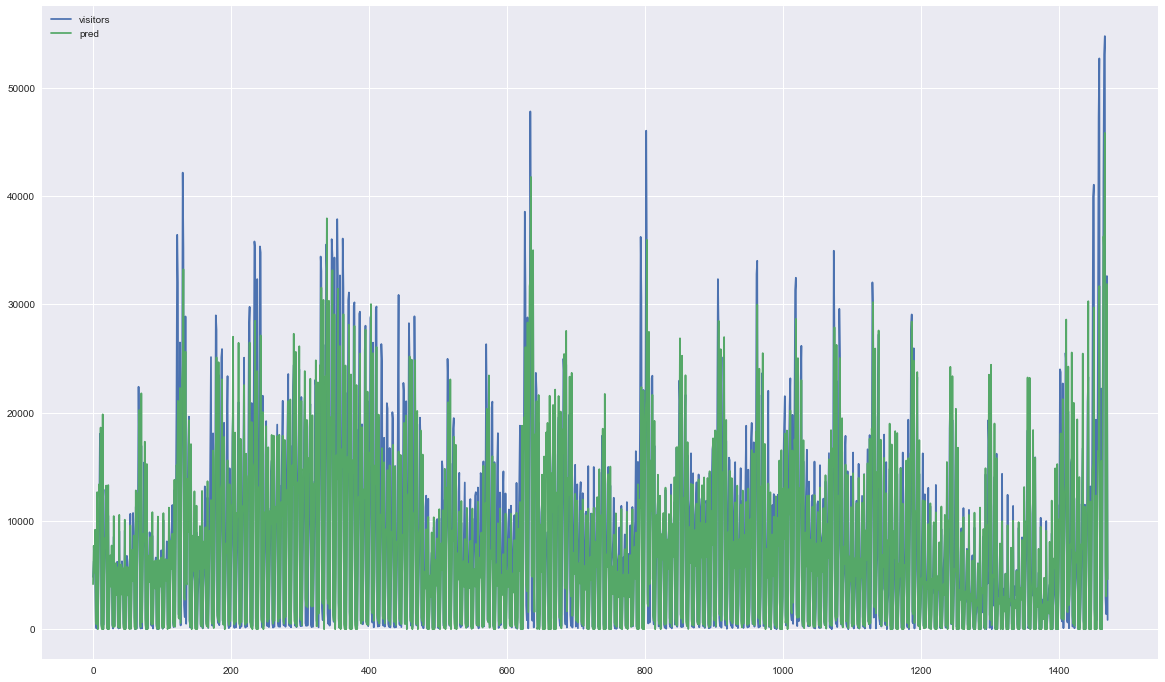

In [1095]:
datasets_tmp = datasets.copy()
datasets_tmp.drop(["park"], axis=1, inplace=True)
train = datasets_tmp["2015-01-01": "2015-012-31"]
val = datasets_tmp["2016-01-01": "2016-06-30"]
test = datasets_tmp["2016-07-01": "2016-12-31"]

def f(df):
    return df.drop(["visitors", "visitors_shift_7", "visitors_shift_14", "visitors_shift_21", "visitors_shift_28"], axis=1), df["visitors"]

X_train, y_train = f(train)
X_val, y_val = f(val)
X_test, y_test = f(test)

pred_val = calc_pred(X_train, y_train, X_val, y_val)
pred_test = calc_pred(X_train, y_train, X_test, y_test)

# ターゲットエンコーディング

In [1117]:
datasets_tmp = datasets.copy()
datasets_tmp.drop(["park"], axis=1, inplace=True)
train = datasets_tmp["2015-01-01": "2016-06-30"]
val = datasets_tmp["2016-01-01": "2016-06-30"]
test = datasets_tmp["2016-07-01": "2016-12-31"]


def f_target_encoding(df, df2, arg, target, visitor_target):
    tmp = df.groupby(arg).agg(
        {
            "max",
            "min",
            "std",
            "skew",
            "mean",
            "count",
            "median",
        }
    )[visitor_target].reset_index()
    
    tmp2 = df2.merge(tmp, on=arg)
    tmp3 = df2.merge(tmp2, how="left")
    tmp3.rename( 
        columns={
            "max": "max_{}_{}".format(visitor_target, target),
            "min": "min_{}_{}".format(visitor_target, target),
            "std": "std_{}_{}".format(visitor_target, target),
            "skew": "skew_{}_{}".format(visitor_target, target),
            "mean": "mean_{}_{}".format(visitor_target, target),
            "count": "count{}_{}".format(visitor_target, target),
            "median": "median{}_{}".format(visitor_target, target),
        },
        inplace=True,
    )

    return tmp3

def target_encoding(df, df2, arg, target):
    df2 = f_target_encoding(df, df2, arg, target, "visitors")
    df2 = f_target_encoding(df, df2, arg, target, "visitors_shift_7")
    df2 = f_target_encoding(df, df2, arg, target, "visitors_shift_14")
#    df2 = f_target_encoding(df, df2, arg, target, "visitors_shift_21")
    df2 = f_target_encoding(df, df2, arg, target, "visitors_shift_28")
    
    return df2

In [1118]:
val = target_encoding(train, val, ["nenmatsu-nenshi", "park_cate"], "nenmatsu-nenshi")
val = target_encoding(train, val, ["gWeek", "park_cate"],"gWeek")
val = target_encoding(train, val, ["sWeek", "park_cate"], "sWeek")
val = target_encoding(train, val, ["obon", "park_cate"], "obon")

# val = target_encoding(train, val, ["gWeek & sWeek", "park_cate"], "gWeek & sWeek")
# val = target_encoding(train, val, ["gWeek & sWeek & obon & nenmatsu-nenshi", "park_cate"], "gWeek & sWeek & obon & nenmatsu-nenshi")

# val = target_encoding(train, val, ["natsu-yasumi", "park_cate"], "natsu-yasumi")
# val = target_encoding(train, val, ["fuyu-yasumi", "park_cate"], "fuyu-yasumi")
# val = target_encoding(train, val, ["haru-yasumi", "park_cate"], "haru-yasumi")
# val = target_encoding(train, val, ["natsu-yasumi & fuyu-yasumi & haru-yasumi", "park_cate"], "natsu-yasumi & fuyu-yasumi & haru-yasumi")

test = target_encoding(train, test, ["nenmatsu-nenshi", "park_cate"], "nenmatsu-nenshi")
test = target_encoding(train, test, ["gWeek", "park_cate"], "gWeek")
test = target_encoding(train, test, ["sWeek", "park_cate"], "sWeek")
test = target_encoding(train, test, ["obon", "park_cate"], "obon")

# test = target_encoding(train, test, ["gWeek & sWeek", "park_cate"], "gWeek & sWeek")
# test = target_encoding(train, test, ["gWeek & sWeek & obon & nenmatsu-nenshi", "park_cate"], "gWeek & sWeek & obon & nenmatsu-nenshi")

# test = target_encoding(train, test, ["natsu-yasumi", "park_cate"], "natsu-yasumi")
# test = target_encoding(train, test, ["fuyu-yasumi", "park_cate"], "fuyu-yasumi")
# test = target_encoding(train, test, ["haru-yasumi", "park_cate"], "haru-yasumi")
# test = target_encoding(train, test, ["natsu-yasumi & fuyu-yasumi & haru-yasumi", "park_cate"], "natsu-yasumi & fuyu-yasumi & haru-yasumi")

train = target_encoding(train, train, ["year", "nenmatsu-nenshi", "park_cate"], "nenmatsu-nenshi")
train = target_encoding(train, train, ["year", "gWeek", "park_cate"], "gWeek")
train = target_encoding(train, train, ["year", "sWeek", "park_cate"], "sWeek")
train = target_encoding(train, train, ["year", "obon", "park_cate"], "obon")

# train = target_encoding(train, train, ["year", "gWeek & sWeek", "park_cate"], "gWeek & sWeek")
# train = target_encoding(train, train, ["year", "gWeek & sWeek & obon & nenmatsu-nenshi", "park_cate"], "gWeek & sWeek & obon & nenmatsu-nenshi")

# train = target_encoding(train, train, ["year", "natsu-yasumi", "park_cate"], "natsu-yasumi")
# train = target_encoding(train, train, ["year", "fuyu-yasumi", "park_cate"], "fuyu-yasumi")
# train = target_encoding(train, train, ["year", "haru-yasumi", "park_cate"], "haru-yasumi")
# train = target_encoding(train, train, ["year", "natsu-yasumi & fuyu-yasumi & haru-yasumi", "park_cate"], "natsu-yasumi & fuyu-yasumi & haru-yasumi")

KeyboardInterrupt: 

In [1119]:
1337.515407288424

1877.7429462264934

1877.7429462264934

1337.515407288424


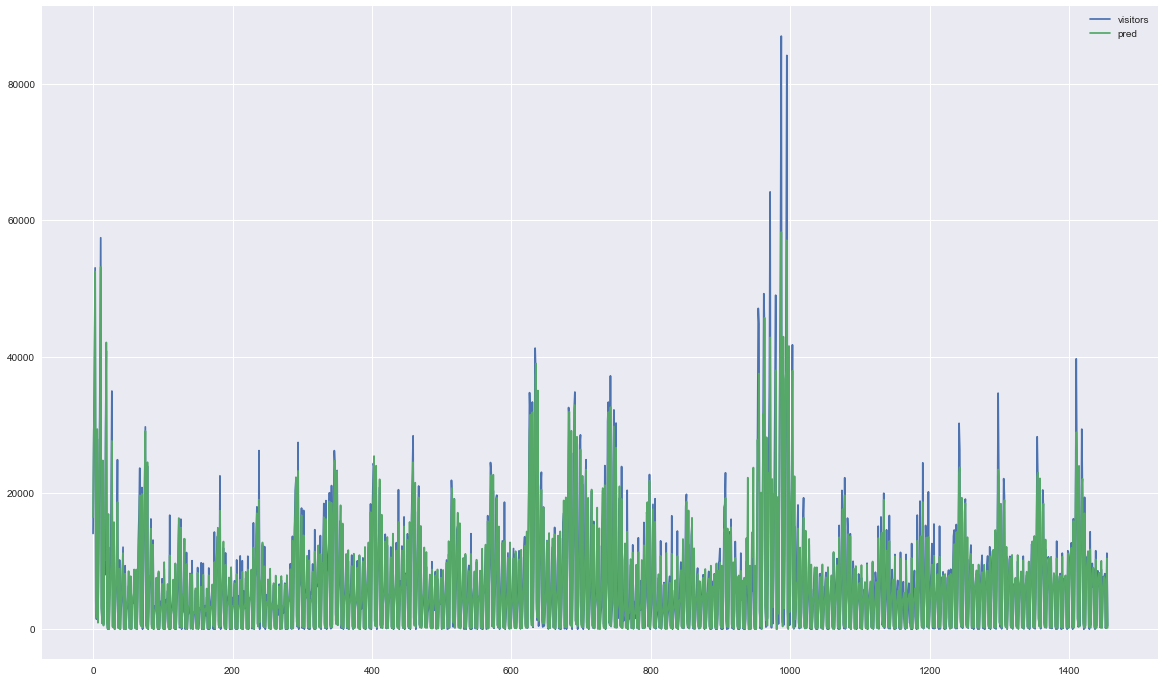

1877.7429462264934


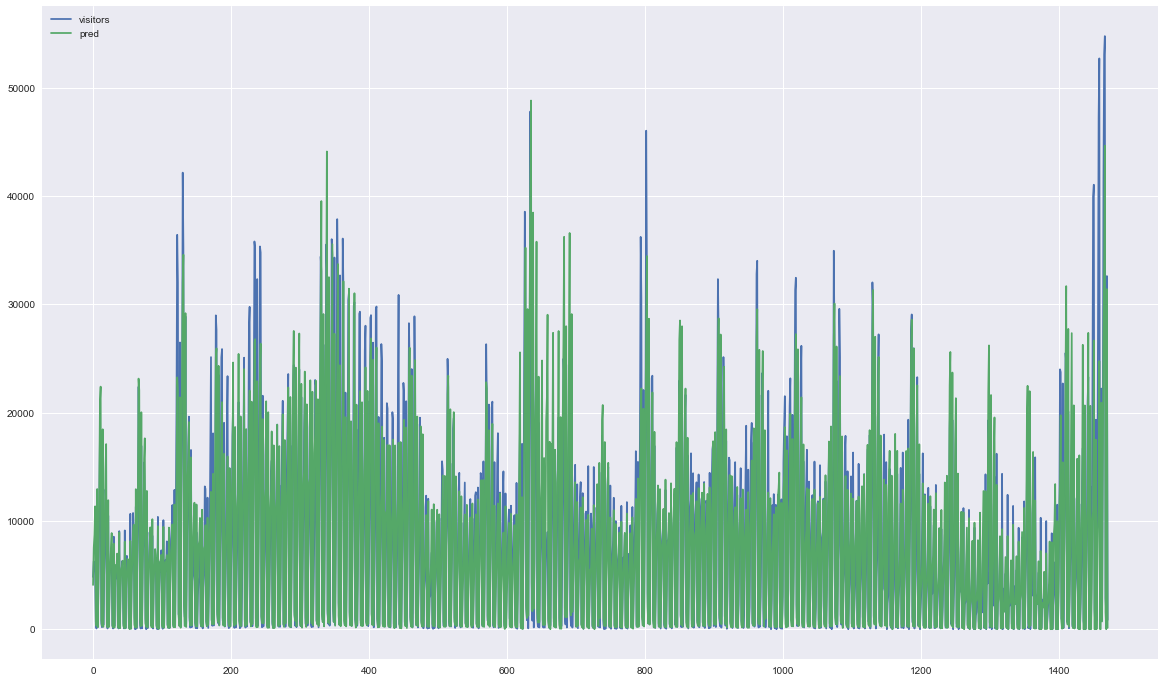

In [1099]:
def f(df):
    return df.drop(["visitors", "visitors_shift_7", "visitors_shift_14", "visitors_shift_28"], axis=1), df["visitors"]

X_train, y_train = f(train)
X_val, y_val = f(val)
X_test, y_test = f(test)

ta_pred_val = calc_pred(X_train, y_train, X_val, y_val)
ta_pred_test = calc_pred(X_train, y_train, X_test, y_test)

In [799]:
ave_pred_val = (pred_val +ta_pred_val) / 2.0

ave_pred_test = (pred_test +ta_pred_test) / 2.0

print(abs(ave_pred_val - y_val).mean())
print(abs(ave_pred_test - y_test).mean())

1099.2501403337662
1825.1437353589158


# 誤差分析

In [ ]:
y_val_tmp = y_val.values
for park in range(8):
    pred_tmp, visit_tmp = [], []
    for idx in range((int)(len(ta_pred_val)/8)):
        pred_tmp.append(ta_pred_val[idx*8 + park])
        visit_tmp.append(y_val_tmp[idx*8 + park])
    print(data_list[park]["park"][0])
    print(abs(np.array(pred_tmp) - np.array(visit_tmp)).mean())
    plt.figure(figsize=(15, 10))
    plt.plot(visit_tmp, label="visitors")
    plt.plot(pred_tmp, label="pred")
    plt.legend()
    plt.show()

In [ ]:
y_val_tmp = y_test.values
for park in range(8):
    pred_tmp, visit_tmp = [], []
    for idx in range((int)(len(ta_pred_test)/8)):
        pred_tmp.append(ta_pred_test[idx*8 + park])
        visit_tmp.append(y_val_tmp[idx*8 + park])
    print(data_list[park]["park"][0])
    print(abs(np.array(pred_tmp) - np.array(visit_tmp)).mean())
    plt.figure(figsize=(15, 10))
    plt.plot(visit_tmp, label="visitors")
    plt.plot(pred_tmp, label="pred")
    plt.legend()
    plt.show()

In [ ]:
y_val_tmp = y_test.values
for park in range(8):
    pred_tmp, visit_tmp = [], []
    for idx in range((int)(len(ta_pred_test)/8)):
        pred_tmp.append(ta_pred_test[idx*8 + park])
        visit_tmp.append(y_val_tmp[idx*8 + park])
    print(data_list[park]["park"][0])
    print(abs(np.array(pred_tmp) - np.array(visit_tmp)).mean())
    plt.figure(figsize=(15, 10))
    plt.plot(visit_tmp, label="visitors")
    plt.plot(pred_tmp, label="pred")
    plt.legend()
    plt.show()

In [ ]:
%%time

from hyperopt import fmin, hp, tpe


def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    
    model = lgb.LGBMRegressor(**params, random_state=0, jobs=-1)
    fit = model.fit(X_train, y_train)
    pred = model.predict(X_val)    
    score = abs(pred - y_val).mean()

    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 3, 100, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf',  5, 50, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

best = fmin(
    objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    )

score = objective(best)
print(score)

In [ ]:
%%time

from hyperopt import fmin, hp, tpe


def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    
    model = lgb.LGBMRegressor(**params, random_state=0, jobs=-1)
    fit = model.fit(X_train, y_train)
    pred = model.predict(X_test)    
    score = abs(pred - y_test).mean()

    return score

score = objective(best)
print(score)

In [20]:
import lightgbm as lgb

def calc_pred(X_train, y_train, X_test, y_test):
    
    model = lgb.LGBMRegressor(random_state=0)
    fit = model.fit(X_train, y_train)
    pred = model.predict(X_test)

    pred = np.clip(pred, 0, 1000000)

    score = abs(pred - y_test).mean()
    print(score)

    plt.figure(figsize=(20, 12))
    plt.plot(y_test.values, label="visitors")
    plt.plot(pred, label="pred")
    plt.legend()
    plt.show()
   
    return pred

/Users/tanabeshogo/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 予測

In [769]:
import xgboost as xgb

In [800]:
datasets_tmp = datasets.copy()
datasets_tmp.drop(["park"], axis=1, inplace=True)
train = datasets_tmp["2015-01-01": "2016-12-31"]
test = datasets_tmp["2017-01-01": "2017-12-31"]

def f(df):
    return df.drop(["visitors", "visitors_shift_7", "visitors_shift_14", "visitors_shift_28"], axis=1), df["visitors"]

X_train, y_train = f(train)
X_test, _ = f(test)

model = lgb.LGBMRegressor(random_state=0, jobs=-1)
fit = model.fit(X_train, y_train)
pred_lgb = model.predict(X_test)    
pred_lgb = np.clip(pred_lgb, 0, 1000000)

model = xgb.XGBRegressor(random_state=0, jobs=-1)
fit = model.fit(X_train, y_train)
pred_xgb = model.predict(X_test)    
pred_xgb = np.clip(pred_xgb, 0, 1000000)


pred = 0.6 * pred_lgb + 0.4 * pred_xgb


#############
#############
test = target_encoding(train, test, ["nenmatsu-nenshi", "park_cate"], "nenmatsu-nenshi")
test = target_encoding(train, test, ["gWeek", "park_cate"], "gWeek")
test = target_encoding(train, test, ["sWeek", "park_cate"], "sWeek")
test = target_encoding(train, test, ["obon", "park_cate"], "obon")

test = target_encoding(train, test, ["gWeek & sWeek", "park_cate"], "gWeek & sWeek")
test = target_encoding(train, test, ["gWeek & sWeek & obon & nenmatsu-nenshi", "park_cate"], "gWeek & sWeek & obon & nenmatsu-nenshi")

test = target_encoding(train, test, ["natsu-yasumi", "park_cate"], "natsu-yasumi")
test = target_encoding(train, test, ["fuyu-yasumi", "park_cate"], "fuyu-yasumi")
test = target_encoding(train, test, ["haru-yasumi", "park_cate"], "haru-yasumi")
test = target_encoding(train, test, ["natsu-yasumi & fuyu-yasumi & haru-yasumi", "park_cate"], "natsu-yasumi & fuyu-yasumi & haru-yasumi")

train = target_encoding(train, train, ["year", "nenmatsu-nenshi", "park_cate"], "nenmatsu-nenshi")
train = target_encoding(train, train, ["year", "gWeek", "park_cate"], "gWeek")
train = target_encoding(train, train, ["year", "sWeek", "park_cate"], "sWeek")
train = target_encoding(train, train, ["year", "obon", "park_cate"], "obon")

train = target_encoding(train, train, ["year", "gWeek & sWeek", "park_cate"], "gWeek & sWeek")
train = target_encoding(train, train, ["year", "gWeek & sWeek & obon & nenmatsu-nenshi", "park_cate"], "gWeek & sWeek & obon & nenmatsu-nenshi")

train = target_encoding(train, train, ["year", "natsu-yasumi", "park_cate"], "natsu-yasumi")
train = target_encoding(train, train, ["year", "fuyu-yasumi", "park_cate"], "fuyu-yasumi")
train = target_encoding(train, train, ["year", "haru-yasumi", "park_cate"], "haru-yasumi")
train = target_encoding(train, train, ["year", "natsu-yasumi & fuyu-yasumi & haru-yasumi", "park_cate"], "natsu-yasumi & fuyu-yasumi & haru-yasumi")

X_train, y_train = f(train)
X_test, _ = f(test)

model = lgb.LGBMRegressor(random_state=0, jobs=-1)
fit = model.fit(X_train, y_train)
pred_tar_lgb = model.predict(X_test)    
pred_tar_lgb = np.clip(pred_tar_lgb, 0, 1000000)

model = xgb.XGBRegressor(random_state=0, jobs=-1)
fit = model.fit(X_train, y_train)
pred_tar_xgb = model.predict(X_test)    
pred_tar_xgb = np.clip(pred_tar_xgb, 0, 1000000)


pred_tar = 0.6 * pred_tar_lgb + 0.4 * pred_tar_xgb


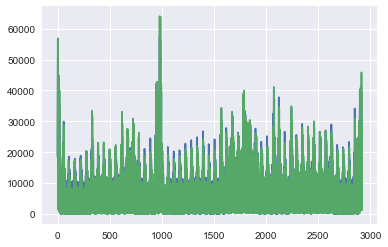

In [801]:
plt.plot(pred)
plt.plot(pred_tar)

In [802]:
pred = (pred + pred_tar) / 2

In [803]:
submit = pd.DataFrame(pred)

In [804]:
submit.head()

,0
0,18744.430677
1,36460.382665
2,44274.360628
3,56726.834064
4,6472.530158


In [805]:
submit.to_csv("../submit/submit_7.tsv", sep="\t", header=None)

# アンサンブル

In [ ]:
pd.read_csv("../submit/submit_1.tsv", sep="\t", header=None, index_col=0, )